In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/current/gui/bi.pickle
147


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t_pen = 0.96

In [5]:
file_ = '2_m.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

/2
file found


In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [0]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
ind_cost = 2
if case in ['2', '4']:
    ind_cost = 1
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [7]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

In [8]:
# get initial parameters and target states

i_range = [20,50]

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003


In [9]:
# get uncontrolled cost
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(wp, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  636.9058225135838
RUN  0 , total integrated cost =  636.9058225135838
Gradient descend method:  None
RUN  0 , total integrated cost =  636.9058225135838
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  797.1477718037709
RUN  0 , total integrated cost =  797.1477718037709
Gradient descend method:  None
RUN  0 , total integrated cost =  797.1477718037709
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [10]:
file_ = '2_m.pickle'

bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  48.6693338482971
RUN  2 , total integrated cost =  44.37245884829697
RUN  3 , total integrated cost =  44.250388535797015
RUN  4 , total integrated cost =  44.25007859164417
RUN  5 , total integrated cost =  44.25006667071607
RUN  6 , total integrated cost =  44.2500661327297
RUN  7 , total integrated cost =  44.25006612203635
RUN  8 , total integrated cost =  44.250066099946906
RUN  9 , total integrated cost =  44.25006608893835
RUN  10 , total integrated cost =  44.2500660641686
RUN  10 , total integrated cost =  44.2500660641686
Improved over  10  iterations in  17.45908998901723  seconds by  71.43670517748298  percent.


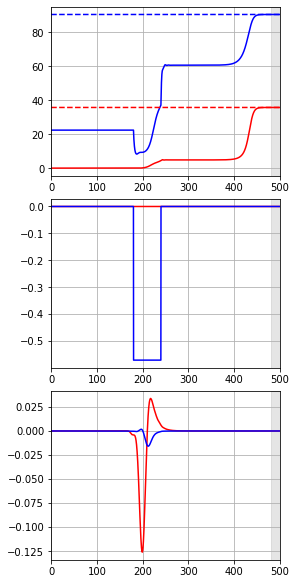

uncontrolled cost :  636.9058225135838
cost splitting :  3.691061797581887e-07 [0.         9.79034173]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  61.16933384829721
RUN  2 , total integrated cost =  55.309958848297555
RUN  3 , total integrated cost =  55.22450962954758
RUN  4 , total integrated cost =  55.218787583649075
RUN  5 , total integrated cost =  55.21860876971455
RUN  6 , total integrated cost =  55.218607567819454
RUN  7 , total integrated cost =  55.218607567819454
Control only changes marginally.
RUN  7 , total integrated cost =  55.218607567819454
Improved over  7  iterations in  0.8936088460031897  seconds by  64.35654208151223  percent.


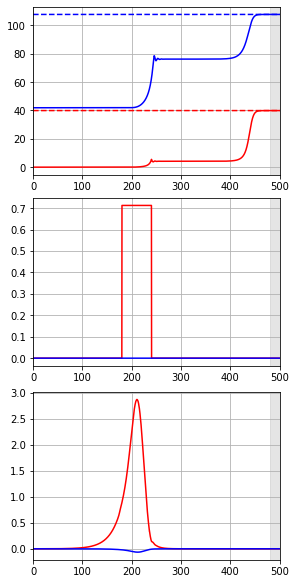

uncontrolled cost :  797.1477718037709
cost splitting :  1.7649065732720294e-07 [15.2454731  0.       ]


In [11]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(10)

    if i == 20:
        control0[0,1,1800:2400] = -2.
        c_var = [1]
    if i == 50:
        control0[0,0,1800:2400] = 2.
        c_var = [0]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
        ax[1].plot(plot_time_array, bestControl_[i][0,0,n_pre-1:-n_post+1], color = 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[1].plot(plot_time_array, bestControl_[i][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')


        ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
        ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][ind_cost][0][:2])    

In [13]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(100)

tol = 1e-13

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i == 20:
        continue
    
    while not conv[i]:

        weight_ = random.random() * ( cost_uncontrolled[i] -
                                     costnode_[i][0][0][0] ) / sum( costnode_[i][ind_cost][0][:] )
            
        aln.params.duration = dur
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][ind_cost][0][:2])

        if conv[i]:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]
        
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
            ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
            ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
            ax[0].set_xlim(-dur_pre,dur+dur_post)
            ax[1].set_xlim(-dur_pre,dur+dur_post)
            ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 28.859577879431225 0.0
interpolate adjoint :  True True True
initial cost =  314.60822792101686
RUN  0 , total integrated cost =  314.60822792101686
Gradient descend method:  None
RUN  1 , total integrated cost =  314.6082279207906
RUN  2 , total integrated cost =  314.6082279207893
RUN  3 , total integrated cost =  314.6082279207893
Control only changes marginally.
RUN  3 , total integrated cost =  314.6082279207893
Improved over  3  iterations in  1.8042393119994813  seconds by  7.23332505003782e-11  percent.
cost splitting :  1.2387098554013066e-07 [7.19220104 3.7091444 ]
set cost params:  0.05 72.62929060728426 0.0
interpolate adjoint :  True True True
initial cost =  791.7569864774845
RUN  0 , total integrated cost =  791.7569864774845
Gradient descend method:  None
RUN  1 , total integrated cost =  791.7569864716485
RUN  2 , total integrated cost =  791.7569

RUN  1 , total integrated cost =  251.5273213984355
RUN  2 , total integrated cost =  251.5273213984336
RUN  3 , total integrated cost =  251.52732139843326
RUN  4 , total integrated cost =  251.52732139843323
RUN  5 , total integrated cost =  251.52732139843235
RUN  6 , total integrated cost =  251.52732139843235
Control only changes marginally.
RUN  6 , total integrated cost =  251.52732139843235
Improved over  6  iterations in  3.863287479000064  seconds by  1.0823555385286454e-09  percent.
cost splitting :  9.639233327817541e-08 [7.19220104 3.7091444 ]
set cost params:  0.05 28.52285843784344 0.0
interpolate adjoint :  True True True
initial cost =  310.9375329690373
RUN  0 , total integrated cost =  310.9375329690373
Gradient descend method:  None
RUN  1 , total integrated cost =  310.937532968883
RUN  2 , total integrated cost =  310.93753296888224
RUN  3 , total integrated cost =  310.93753296888076
RUN  4 , total integrated cost =  310.93753296887957
RUN  5 , total integrated c

RUN  1 , total integrated cost =  304.4531963969818
RUN  2 , total integrated cost =  304.4531963969788
RUN  3 , total integrated cost =  304.4531963969788
Control only changes marginally.
RUN  3 , total integrated cost =  304.4531963969788
Improved over  3  iterations in  2.69462800600013  seconds by  1.3813235000270652e-09  percent.
cost splitting :  1.1888088920722845e-07 [7.19220104 3.70914441]
set cost params:  0.05 58.27788433827851 0.0
interpolate adjoint :  True True True
initial cost =  635.3073490889511
RUN  0 , total integrated cost =  635.3073490889511
Gradient descend method:  None
RUN  1 , total integrated cost =  635.3073490857888
RUN  2 , total integrated cost =  635.3073490857861
RUN  3 , total integrated cost =  635.3073490857853
RUN  4 , total integrated cost =  635.3073490857636
RUN  5 , total integrated cost =  635.3073490857421
RUN  6 , total integrated cost =  635.3073490857414
RUN  7 , total integrated cost =  635.3073490857407
RUN  8 , total integrated cost =  

RUN  1 , total integrated cost =  50.89188943634724
RUN  2 , total integrated cost =  50.891889436346894
RUN  3 , total integrated cost =  50.891889436346894
Control only changes marginally.
RUN  3 , total integrated cost =  50.891889436346894
Improved over  3  iterations in  2.6776921979999315  seconds by  1.798447613055032e-08  percent.
cost splitting :  2.176033418931126e-08 [7.19220104 3.70914441]
set cost params:  0.05 57.67551034663729 0.0
interpolate adjoint :  True True True
initial cost =  628.740662132825
RUN  0 , total integrated cost =  628.740662132825
Gradient descend method:  None
RUN  1 , total integrated cost =  628.7406621142087
RUN  2 , total integrated cost =  628.7406621141796
RUN  3 , total integrated cost =  628.7406621141741
RUN  4 , total integrated cost =  628.7406621141721
RUN  5 , total integrated cost =  628.7406621141718
RUN  6 , total integrated cost =  628.7406621141718
Control only changes marginally.
RUN  6 , total integrated cost =  628.7406621141718


RUN  1 , total integrated cost =  722.1645916621649
RUN  2 , total integrated cost =  722.16459166216
RUN  3 , total integrated cost =  722.1645916621519
RUN  4 , total integrated cost =  722.1645916621502
RUN  5 , total integrated cost =  722.1645916621493
RUN  6 , total integrated cost =  722.1645916621466
RUN  7 , total integrated cost =  722.1645916621466
Control only changes marginally.
RUN  7 , total integrated cost =  722.1645916621466
Improved over  7  iterations in  3.2764853360004054  seconds by  4.985167834092863e-10  percent.
cost splitting :  3.113798406436121e-07 [7.19220104 3.70914441]
set cost params:  0.05 59.96314259297802 0.0
interpolate adjoint :  True True True
initial cost =  653.6789314856649
RUN  0 , total integrated cost =  653.6789314856649
Gradient descend method:  None
RUN  1 , total integrated cost =  653.6789314855724
RUN  2 , total integrated cost =  653.6789314855674
RUN  3 , total integrated cost =  653.6789314855602
RUN  4 , total integrated cost =  65

RUN  1 , total integrated cost =  282.98238512249486
RUN  2 , total integrated cost =  282.9823851224947
RUN  3 , total integrated cost =  282.98238512249435
RUN  4 , total integrated cost =  282.98238512249435
Control only changes marginally.
RUN  4 , total integrated cost =  282.98238512249435
Improved over  4  iterations in  2.0567502550002246  seconds by  2.34052777159377e-11  percent.
cost splitting :  1.0841230744588419e-07 [7.16154852 3.73950974]
set cost params:  0.05 31.16873280079823 0.0
interpolate adjoint :  True True True
initial cost =  339.7721721271249
RUN  0 , total integrated cost =  339.7721721271249
Gradient descend method:  None
RUN  1 , total integrated cost =  339.7721721269961
RUN  2 , total integrated cost =  339.7721721269961
Control only changes marginally.
RUN  2 , total integrated cost =  339.7721721269961
Improved over  2  iterations in  1.8449420020006073  seconds by  3.7914560380158946e-11  percent.
cost splitting :  1.329208248857829e-07 [7.16154852 3.7

RUN  7 , total integrated cost =  258.2897386971119
RUN  8 , total integrated cost =  258.2897386971119
Control only changes marginally.
RUN  8 , total integrated cost =  258.2897386971119
Improved over  8  iterations in  5.550210662000609  seconds by  2.0386323740240186e-09  percent.
cost splitting :  9.770111837754452e-08 [7.16154852 3.73950974]
set cost params:  0.05 61.86885506981004 0.0
interpolate adjoint :  True True True
initial cost =  674.4359935390507
RUN  0 , total integrated cost =  674.4359935390507
Gradient descend method:  None
RUN  1 , total integrated cost =  674.4359935338008
RUN  2 , total integrated cost =  674.435993533781
RUN  3 , total integrated cost =  674.435993533779
RUN  4 , total integrated cost =  674.4359935337724
RUN  5 , total integrated cost =  674.4359935337717
RUN  6 , total integrated cost =  674.4359935337686
RUN  7 , total integrated cost =  674.4359935337644
RUN  8 , total integrated cost =  674.4359935337637
RUN  9 , total integrated cost =  67

RUN  1 , total integrated cost =  613.6327405123777
RUN  2 , total integrated cost =  613.6327405123777
Control only changes marginally.
RUN  2 , total integrated cost =  613.6327405123777
Improved over  2  iterations in  1.8552966940005717  seconds by  2.5082158572331537e-11  percent.
cost splitting :  2.601482976456043e-07 [7.16154852 3.73950974]
set cost params:  0.05 34.85585340348631 0.0
interpolate adjoint :  True True True
initial cost =  379.96568862404416
RUN  0 , total integrated cost =  379.96568862404416
Gradient descend method:  None
RUN  1 , total integrated cost =  379.9656886228206
RUN  2 , total integrated cost =  379.96568862281975
RUN  3 , total integrated cost =  379.96568862281913
RUN  4 , total integrated cost =  379.9656886228147
RUN  5 , total integrated cost =  379.96568862280986
RUN  6 , total integrated cost =  379.9656886227778
RUN  7 , total integrated cost =  379.96568862274444
RUN  8 , total integrated cost =  379.96568862274444
Control only changes margi

RUN  2 , total integrated cost =  748.7123237349098
RUN  3 , total integrated cost =  748.7123237349098
Control only changes marginally.
RUN  3 , total integrated cost =  748.7123237349098
Improved over  3  iterations in  1.6112947330002498  seconds by  1.1019096746167634e-10  percent.
cost splitting :  3.2182421770943705e-07 [7.16154851 3.73950974]
set cost params:  0.05 18.767692194368365 0.0
interpolate adjoint :  True True True
initial cost =  204.58770600831875
RUN  0 , total integrated cost =  204.58770600831875
Gradient descend method:  None
RUN  1 , total integrated cost =  204.5877060019294
RUN  2 , total integrated cost =  204.58770600191912
RUN  3 , total integrated cost =  204.5877060019187
RUN  4 , total integrated cost =  204.5877060019182
RUN  5 , total integrated cost =  204.58770600191724
RUN  6 , total integrated cost =  204.58770600191724
Control only changes marginally.
RUN  6 , total integrated cost =  204.58770600191724
Improved over  6  iterations in  3.138053121

RUN  1 , total integrated cost =  480.4522364985329
RUN  2 , total integrated cost =  480.45223649853074
RUN  3 , total integrated cost =  480.45223649853074
Control only changes marginally.
RUN  3 , total integrated cost =  480.45223649853074
Improved over  3  iterations in  1.765930085999571  seconds by  3.2028424357122276e-10  percent.
cost splitting :  1.9653021786708925e-07 [7.16154851 3.73950975]
set cost params:  0.05 16.96246635132473 0.0
interpolate adjoint :  True True True
initial cost =  184.90883391869596
RUN  0 , total integrated cost =  184.90883391869596
Gradient descend method:  None
RUN  1 , total integrated cost =  184.90883391606033
RUN  2 , total integrated cost =  184.90883391605828
RUN  3 , total integrated cost =  184.90883391605828
Control only changes marginally.
RUN  3 , total integrated cost =  184.90883391605828
Improved over  3  iterations in  1.6733933230007096  seconds by  1.426471385457262e-09  percent.
cost splitting :  6.760917612725101e-08 [7.1615485

RUN  2 , total integrated cost =  421.22835406505925
Control only changes marginally.
RUN  2 , total integrated cost =  421.22835406505925
Improved over  2  iterations in  1.1723879510000188  seconds by  2.1032064978498966e-12  percent.
cost splitting :  1.7153232562840294e-07 [7.16154851 3.73950975]
set cost params:  0.05 50.283629832886135 0.0
interpolate adjoint :  True True True
initial cost =  548.1447782821341
RUN  0 , total integrated cost =  548.1447782821341
Gradient descend method:  None
RUN  1 , total integrated cost =  548.144778281737
RUN  2 , total integrated cost =  548.1447782817362
RUN  3 , total integrated cost =  548.1447782817362
Control only changes marginally.
RUN  3 , total integrated cost =  548.1447782817362
Improved over  3  iterations in  1.6828983000004882  seconds by  7.258904588525183e-11  percent.
cost splitting :  2.2712700465333603e-07 [7.16154851 3.73950975]
set cost params:  0.05 13.34097698470973 0.0
interpolate adjoint :  True True True
initial cost

RUN  1 , total integrated cost =  102.25226851299828
RUN  2 , total integrated cost =  102.2522685129914
RUN  3 , total integrated cost =  102.2522685129914
Control only changes marginally.
RUN  3 , total integrated cost =  102.2522685129914
Improved over  3  iterations in  2.1798123709995707  seconds by  6.724292234139284e-09  percent.
cost splitting :  3.5282556767828005e-08 [7.16154851 3.73950975]
set cost params:  0.05 8.245571367048303 0.0
interpolate adjoint :  True True True
initial cost =  89.88545385377994
RUN  0 , total integrated cost =  89.88545385377994
Gradient descend method:  None
RUN  1 , total integrated cost =  89.88545385376797
RUN  2 , total integrated cost =  89.88545385376733
RUN  3 , total integrated cost =  89.88545385376685
RUN  4 , total integrated cost =  89.88545385376685
Control only changes marginally.
RUN  4 , total integrated cost =  89.88545385376685
Improved over  4  iterations in  1.9874298769991583  seconds by  1.4566126083082054e-11  percent.
cost 

RUN  3 , total integrated cost =  361.2396358397266
RUN  4 , total integrated cost =  361.23963583972386
RUN  5 , total integrated cost =  361.23963583972386
Control only changes marginally.
RUN  5 , total integrated cost =  361.23963583972386
Improved over  5  iterations in  2.5228634089999105  seconds by  2.162053647225548e-09  percent.
cost splitting :  1.434878214118097e-07 [7.16154851 3.73950975]
set cost params:  0.05 12.666232861529972 0.0
interpolate adjoint :  True True True
initial cost =  138.07534235075425
RUN  0 , total integrated cost =  138.07534235075425
Gradient descend method:  None
RUN  1 , total integrated cost =  138.07534234879725
RUN  2 , total integrated cost =  138.075342348795
RUN  3 , total integrated cost =  138.0753423487948
RUN  4 , total integrated cost =  138.07534234879475
RUN  5 , total integrated cost =  138.07534234879404
RUN  6 , total integrated cost =  138.07534234879404
Control only changes marginally.
RUN  6 , total integrated cost =  138.075342

RUN  9 , total integrated cost =  306.91451207291436
RUN  10 , total integrated cost =  306.91451207291396
RUN  11 , total integrated cost =  306.91451207291396
Control only changes marginally.
RUN  11 , total integrated cost =  306.91451207291396
Improved over  11  iterations in  3.959528391999811  seconds by  5.827160975968582e-10  percent.
cost splitting :  1.1997780040413338e-07 [7.16154851 3.73950975]
set cost params:  0.05 42.94688785086824 0.0
interpolate adjoint :  True True True
initial cost =  468.1665265049466
RUN  0 , total integrated cost =  468.1665265049466
Gradient descend method:  None
RUN  1 , total integrated cost =  468.16652650413096
RUN  2 , total integrated cost =  468.1665265041278
RUN  3 , total integrated cost =  468.1665265041278
Control only changes marginally.
RUN  3 , total integrated cost =  468.1665265041278
Improved over  3  iterations in  1.9359812290003902  seconds by  1.7490719983470626e-10  percent.
cost splitting :  1.9113655085765665e-07 [7.161548

RUN  1 , total integrated cost =  233.32637758835764
RUN  2 , total integrated cost =  233.32637758835622
RUN  3 , total integrated cost =  233.3263775883562
RUN  4 , total integrated cost =  233.3263775883562
Control only changes marginally.
RUN  4 , total integrated cost =  233.3263775883562
Improved over  4  iterations in  3.236782241000583  seconds by  7.280220870597987e-11  percent.
cost splitting :  8.712450374567981e-08 [7.1615485  3.73950975]
set cost params:  0.05 6.905637869833594 0.0
interpolate adjoint :  True True True
initial cost =  75.2787607383505
RUN  0 , total integrated cost =  75.2787607383505
Gradient descend method:  None
RUN  1 , total integrated cost =  75.27876073691375
RUN  2 , total integrated cost =  75.27876073691242
RUN  3 , total integrated cost =  75.27876073691228
RUN  4 , total integrated cost =  75.2787607369117
RUN  5 , total integrated cost =  75.2787607369117
Control only changes marginally.
RUN  5 , total integrated cost =  75.2787607369117
Impro

RUN  1 , total integrated cost =  688.3993984275867
RUN  2 , total integrated cost =  688.3993984275833
RUN  3 , total integrated cost =  688.3993984275832
RUN  4 , total integrated cost =  688.3993984275832
Control only changes marginally.
RUN  4 , total integrated cost =  688.3993984275832
Improved over  4  iterations in  3.5174152019999383  seconds by  1.5165824152063578e-09  percent.
cost splitting :  2.896544363827905e-07 [7.1615485  3.73950976]
set cost params:  0.05 4.30747123451383 0.0
interpolate adjoint :  True True True
initial cost =  46.95599488928515
RUN  0 , total integrated cost =  46.95599488928515
Gradient descend method:  None
RUN  1 , total integrated cost =  46.955994878164475
RUN  2 , total integrated cost =  46.95599487815888
RUN  3 , total integrated cost =  46.95599487815883
RUN  4 , total integrated cost =  46.9559948781587
RUN  5 , total integrated cost =  46.95599487815859
RUN  6 , total integrated cost =  46.95599487815852
RUN  7 , total integrated cost =  

RUN  1 , total integrated cost =  185.66903453957443
RUN  2 , total integrated cost =  185.66903453957408
RUN  3 , total integrated cost =  185.6690345395738
RUN  4 , total integrated cost =  185.66903453957357
RUN  5 , total integrated cost =  185.66903453957357
Control only changes marginally.
RUN  5 , total integrated cost =  185.66903453957357
Improved over  5  iterations in  2.606018731000404  seconds by  1.3045138302913983e-09  percent.
cost splitting :  6.722566115076168e-08 [7.1615485  3.73950976]
set cost params:  0.05 44.37679816986519 0.0
interpolate adjoint :  True True True
initial cost =  483.7540621978339
RUN  0 , total integrated cost =  483.7540621978339
Gradient descend method:  None
RUN  1 , total integrated cost =  483.75406219420864
RUN  2 , total integrated cost =  483.7540621942031
RUN  3 , total integrated cost =  483.7540621942031
Control only changes marginally.
RUN  3 , total integrated cost =  483.7540621942031
Improved over  3  iterations in  2.248747011999

RUN  1 , total integrated cost =  99.43246651161618
RUN  2 , total integrated cost =  99.43246651160811
RUN  3 , total integrated cost =  99.43246651160777
RUN  4 , total integrated cost =  99.43246651160743
RUN  5 , total integrated cost =  99.43246651160723
RUN  6 , total integrated cost =  99.43246651160723
Control only changes marginally.
RUN  6 , total integrated cost =  99.43246651160723
Improved over  6  iterations in  3.5400511440002447  seconds by  8.883503710421792e-09  percent.
cost splitting :  3.4398531123835153e-08 [7.1615485  3.73950976]
set cost params:  0.05 37.416495632348266 0.0
interpolate adjoint :  True True True
initial cost =  407.87939873918936
RUN  0 , total integrated cost =  407.87939873918936
Gradient descend method:  None
RUN  1 , total integrated cost =  407.8793987338038
RUN  2 , total integrated cost =  407.87939873380077
RUN  3 , total integrated cost =  407.8793987338005
RUN  4 , total integrated cost =  407.87939873379963
RUN  5 , total integrated co

RUN  1 , total integrated cost =  77.92748046865736
RUN  2 , total integrated cost =  77.92748046865387
RUN  3 , total integrated cost =  77.92748046865384
RUN  4 , total integrated cost =  77.92748046865327
RUN  5 , total integrated cost =  77.92748046865279
RUN  6 , total integrated cost =  77.92748046865273
RUN  7 , total integrated cost =  77.92748046865273
Control only changes marginally.
RUN  7 , total integrated cost =  77.92748046865273
Improved over  7  iterations in  3.808825104999414  seconds by  4.693518462772772e-09  percent.
cost splitting :  2.723620580403777e-08 [7.1615485  3.73950976]
set cost params:  0.05 49.8716729053471 0.0
interpolate adjoint :  True True True
initial cost =  543.6540118198454
RUN  0 , total integrated cost =  543.6540118198454
Gradient descend method:  None
RUN  1 , total integrated cost =  543.6540118081733
RUN  2 , total integrated cost =  543.6540118081457
RUN  3 , total integrated cost =  543.6540118081457
Control only changes marginally.
RUN

RUN  1 , total integrated cost =  642.3968260477081
RUN  2 , total integrated cost =  642.3968260477055
RUN  3 , total integrated cost =  642.3968260477055
Control only changes marginally.
RUN  3 , total integrated cost =  642.3968260477055
Improved over  3  iterations in  1.754938308000419  seconds by  1.3699263945454732e-11  percent.
cost splitting :  2.688930469509223e-07 [7.1615485  3.73950976]
set cost params:  0.05 51.42425945331426 0.0
interpolate adjoint :  True True True
initial cost =  560.5788482185355
RUN  0 , total integrated cost =  560.5788482185355
Gradient descend method:  None
RUN  1 , total integrated cost =  560.5788482184244
RUN  2 , total integrated cost =  560.578848218423
RUN  3 , total integrated cost =  560.5788482184216
RUN  4 , total integrated cost =  560.5788482184204
RUN  5 , total integrated cost =  560.5788482184204
Control only changes marginally.
RUN  5 , total integrated cost =  560.5788482184204
Improved over  5  iterations in  2.7291206820000298  s

RUN  1 , total integrated cost =  193.65758635373345
RUN  2 , total integrated cost =  193.65758635372515
RUN  3 , total integrated cost =  193.65758635372487
RUN  4 , total integrated cost =  193.65758635372487
Control only changes marginally.
RUN  4 , total integrated cost =  193.65758635372487
Improved over  4  iterations in  2.323436120000224  seconds by  2.300922119502502e-09  percent.
cost splitting :  7.067250537476309e-08 [7.16154849 3.73950977]
set cost params:  0.05 51.262287430799056 0.0
interpolate adjoint :  True True True
initial cost =  558.8131817690643
RUN  0 , total integrated cost =  558.8131817690643
Gradient descend method:  None
RUN  1 , total integrated cost =  558.8131817640666
RUN  2 , total integrated cost =  558.8131817640533
RUN  3 , total integrated cost =  558.8131817640517
RUN  4 , total integrated cost =  558.8131817640497
RUN  5 , total integrated cost =  558.8131817640497
Control only changes marginally.
RUN  5 , total integrated cost =  558.8131817640

RUN  7 , total integrated cost =  257.8236437353874
RUN  8 , total integrated cost =  257.8236437353861
RUN  9 , total integrated cost =  257.82364373538576
RUN  10 , total integrated cost =  257.82364373538576
Control only changes marginally.
RUN  10 , total integrated cost =  257.82364373538576
Improved over  10  iterations in  3.872868466  seconds by  1.403549276801641e-09  percent.
cost splitting :  9.752729171059351e-08 [7.16154849 3.73950977]
set cost params:  0.05 49.74501768412751 0.0
interpolate adjoint :  True True True
initial cost =  542.2733358635637
RUN  0 , total integrated cost =  542.2733358635637
Gradient descend method:  None
RUN  1 , total integrated cost =  542.273335860871
RUN  2 , total integrated cost =  542.273335860862
RUN  3 , total integrated cost =  542.2733358608442
RUN  4 , total integrated cost =  542.2733358608281
RUN  5 , total integrated cost =  542.2733358608275
RUN  6 , total integrated cost =  542.2733358608274
RUN  7 , total integrated cost =  542

RUN  1 , total integrated cost =  518.1808176562624
RUN  2 , total integrated cost =  518.1808176562598
RUN  3 , total integrated cost =  518.1808176562536
RUN  4 , total integrated cost =  518.1808176562536
Control only changes marginally.
RUN  4 , total integrated cost =  518.1808176562536
Improved over  4  iterations in  3.54981077299999  seconds by  2.241478114228812e-10  percent.
cost splitting :  2.1555577572554717e-07 [7.16154849 3.73950977]
set cost params:  0.05 32.599009034350395 0.0
interpolate adjoint :  True True True
initial cost =  355.3636966664689
RUN  0 , total integrated cost =  355.3636966664689
Gradient descend method:  None
RUN  1 , total integrated cost =  355.3636966657918
RUN  2 , total integrated cost =  355.3636966657913
RUN  3 , total integrated cost =  355.36369666579003
RUN  4 , total integrated cost =  355.363696665788
RUN  5 , total integrated cost =  355.3636966657876
RUN  6 , total integrated cost =  355.3636966657876
Control only changes marginally.
R

RUN  1 , total integrated cost =  741.7275687386866
RUN  2 , total integrated cost =  741.7275687386866
Control only changes marginally.
RUN  2 , total integrated cost =  741.7275687386866
Improved over  2  iterations in  1.4391092409996418  seconds by  2.923172814917052e-11  percent.
cost splitting :  3.1885052643450506e-07 [7.16154849 3.73950977]
set cost params:  0.05 22.969542227750445 0.0
interpolate adjoint :  True True True
initial cost =  250.3923180114446
RUN  0 , total integrated cost =  250.3923180114446
Gradient descend method:  None
RUN  1 , total integrated cost =  250.3923180063726
RUN  2 , total integrated cost =  250.3923180063711
RUN  3 , total integrated cost =  250.39231800637066
RUN  4 , total integrated cost =  250.39231800637066
Control only changes marginally.
RUN  4 , total integrated cost =  250.39231800637066
Improved over  4  iterations in  3.1839379360008024  seconds by  2.0263968281142297e-09  percent.
cost splitting :  9.390039168749758e-08 [7.16154849 3.

RUN  1 , total integrated cost =  9.198560079863082
RUN  2 , total integrated cost =  9.198560079862954
RUN  3 , total integrated cost =  9.198560079862954
Control only changes marginally.
RUN  3 , total integrated cost =  9.198560079862954
Improved over  3  iterations in  2.169594513999982  seconds by  8.306565746352135e-08  percent.
cost splitting :  2.2732365351032217e-08 [6.98909011 3.91134218]
set cost params:  0.05 46.44108487835333 0.0
interpolate adjoint :  True True True
initial cost =  506.22790136472526
RUN  0 , total integrated cost =  506.22790136472526
Gradient descend method:  None
RUN  1 , total integrated cost =  506.2279013469562
RUN  2 , total integrated cost =  506.22790134693656
RUN  3 , total integrated cost =  506.2279013469362
RUN  4 , total integrated cost =  506.22790134693565
RUN  5 , total integrated cost =  506.2279013469352
RUN  6 , total integrated cost =  506.2279013469349
RUN  7 , total integrated cost =  506.2279013469346
RUN  8 , total integrated cost

RUN  1 , total integrated cost =  566.6167822898034
RUN  2 , total integrated cost =  566.616782289801
RUN  3 , total integrated cost =  566.6167822897988
RUN  4 , total integrated cost =  566.6167822897969
RUN  5 , total integrated cost =  566.6167822897969
Control only changes marginally.
RUN  5 , total integrated cost =  566.6167822897969
Improved over  5  iterations in  2.7208931859995573  seconds by  2.1698980390283396e-09  percent.
cost splitting :  2.3378847993290638e-07 [6.98909011 3.91134218]
set cost params:  0.05 57.82433606357441 0.0
interpolate adjoint :  True True True
initial cost =  630.3102601668941
RUN  0 , total integrated cost =  630.3102601668941
Gradient descend method:  None
RUN  1 , total integrated cost =  630.3102601668171
RUN  2 , total integrated cost =  630.3102601668022
RUN  3 , total integrated cost =  630.3102601667897
RUN  4 , total integrated cost =  630.3102601667825
RUN  5 , total integrated cost =  630.3102601667747
RUN  6 , total integrated cost = 

RUN  1 , total integrated cost =  724.0495057905514
RUN  2 , total integrated cost =  724.0495057905505
RUN  3 , total integrated cost =  724.0495057905505
Control only changes marginally.
RUN  3 , total integrated cost =  724.0495057905505
Improved over  3  iterations in  2.8567950189999465  seconds by  3.5459919445202104e-09  percent.
cost splitting :  3.0428569465802663e-07 [6.98909011 3.91134218]
set cost params:  0.05 64.0101975979117 0.0
interpolate adjoint :  True True True
initial cost =  697.7388249959419
RUN  0 , total integrated cost =  697.7388249959419
Gradient descend method:  None
RUN  1 , total integrated cost =  697.7388249959297
RUN  2 , total integrated cost =  697.7388249959278
RUN  3 , total integrated cost =  697.7388249959275
RUN  4 , total integrated cost =  697.7388249959275
Control only changes marginally.
RUN  4 , total integrated cost =  697.7388249959275
Improved over  4  iterations in  2.931417851000333  seconds by  2.0605739337042905e-12  percent.
cost sp

RUN  1 , total integrated cost =  236.39706844339486
RUN  2 , total integrated cost =  236.39706844338954
RUN  3 , total integrated cost =  236.39706844338895
RUN  4 , total integrated cost =  236.39706844338826
RUN  5 , total integrated cost =  236.3970684433881
RUN  6 , total integrated cost =  236.39706844338355
RUN  7 , total integrated cost =  236.39706844337903
RUN  8 , total integrated cost =  236.39706844337903
Control only changes marginally.
RUN  8 , total integrated cost =  236.39706844337903
Improved over  8  iterations in  4.887902200999633  seconds by  1.8463452988726203e-09  percent.
cost splitting :  9.28373767887746e-08 [6.98909012 3.91134218]
set cost params:  0.05 5.512468560480931 0.0
interpolate adjoint :  True True True
initial cost =  60.08829031713277
RUN  0 , total integrated cost =  60.08829031713277
Gradient descend method:  None
RUN  1 , total integrated cost =  60.088290315455275
RUN  2 , total integrated cost =  60.08829031545371
RUN  3 , total integrated 

RUN  2 , total integrated cost =  501.3306106218058
RUN  3 , total integrated cost =  501.3306106216987
RUN  4 , total integrated cost =  501.33061062158725
RUN  5 , total integrated cost =  501.3306106215871
RUN  6 , total integrated cost =  501.3306106215807
RUN  7 , total integrated cost =  501.3306106215719
RUN  8 , total integrated cost =  501.33061062157105
RUN  9 , total integrated cost =  501.3306106215703
RUN  10 , total integrated cost =  501.3306106215703
Control only changes marginally.
RUN  10 , total integrated cost =  501.3306106215703
Improved over  10  iterations in  6.322341781999967  seconds by  2.887077243940439e-10  percent.
cost splitting :  2.051624404682743e-07 [6.98909012 3.91134218]
set cost params:  0.05 21.154782751611506 0.0
interpolate adjoint :  True True True
initial cost =  230.59627706993416
RUN  0 , total integrated cost =  230.59627706993416
Gradient descend method:  None
RUN  1 , total integrated cost =  230.59627706797878
RUN  2 , total integrated 

RUN  1 , total integrated cost =  301.53106319574334
RUN  2 , total integrated cost =  301.5310631957421
RUN  3 , total integrated cost =  301.5310631957415
RUN  4 , total integrated cost =  301.5310631957397
RUN  5 , total integrated cost =  301.53106319573607
RUN  6 , total integrated cost =  301.5310631957359
RUN  7 , total integrated cost =  301.5310631957359
Control only changes marginally.
RUN  7 , total integrated cost =  301.5310631957359
Improved over  7  iterations in  3.73654460599937  seconds by  7.660787559871096e-10  percent.
cost splitting :  1.1944211374656648e-07 [6.98909012 3.91134218]
set cost params:  0.05 67.16336660848799 0.0
interpolate adjoint :  True True True
initial cost =  732.109730307753
RUN  0 , total integrated cost =  732.109730307753
Gradient descend method:  None
RUN  1 , total integrated cost =  732.1097303030232
RUN  2 , total integrated cost =  732.1097303030218
RUN  3 , total integrated cost =  732.1097303030209
RUN  4 , total integrated cost =  7

KeyboardInterrupt: 

-------  20 0.4500000000000001 0.4750000000000002


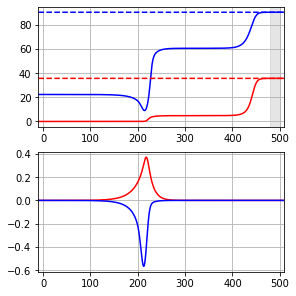

-------  50 0.47500000000000014 0.6000000000000003


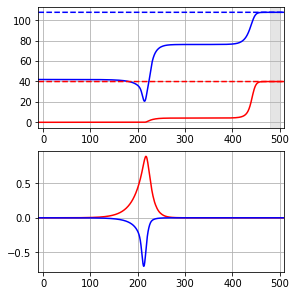

In [68]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

In [14]:
file_ = '2_p.pickle'

bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  791.8252532802787
RUN  0 , total integrated cost =  791.8252532802787
Gradient descend method:  None
RUN  1 , total integrated cost =  45.124496186489395
RUN  2 , total integrated cost =  41.63408336936326
RUN  3 , total integrated cost =  41.45290152134785
RUN  4 , total integrated cost =  41.44785197805104
RUN  5 , total integrated cost =  41.44776614285335
RUN  6 , total integrated cost =  41.447730512855884
RUN  7 , total integrated cost =  41.447648349403536
RUN  8 , total integrated cost =  41.447615404570854
RUN  9 , total integrated cost =  41.447547125284125
RUN  10 , total integrated cost =  41.44750964869578
RUN  10 , total integrated cost =  41.44750964869578
Improved over  10  iterations in  2.813267061021179  seconds by  94.7655736569411  percent.


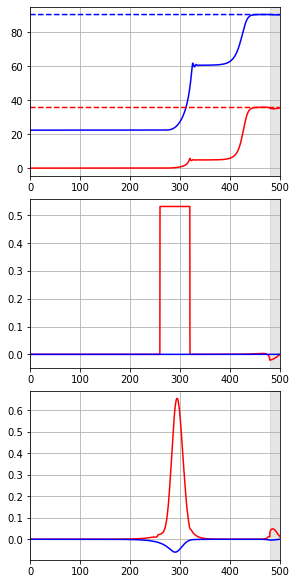

uncontrolled cost :  636.9058225135838
cost splitting :  3.9543086652103545 [4.12497942 0.        ]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  952.0671070839994
RUN  0 , total integrated cost =  952.0671070839994
Gradient descend method:  None
RUN  1 , total integrated cost =  70.08067624925678
RUN  2 , total integrated cost =  55.237917873336215
RUN  3 , total integrated cost =  55.22110515875805
RUN  4 , total integrated cost =  55.21967252665845
RUN  5 , total integrated cost =  55.2196099101616
RUN  6 , total integrated cost =  55.11922084765927
RUN  7 , total integrated cost =  54.11959572797823
RUN  8 , total integrated cost =  54.0737645515848
RUN  9 , total integrated cost =  54.071266230828115
RUN  10 , total integrated cost =  54.07092686161228
RUN  10 , total integrated cost =  54.07092686161228
Improved over  10  iterations in  2.9615874610026367  seconds by  94.32068113063781  per

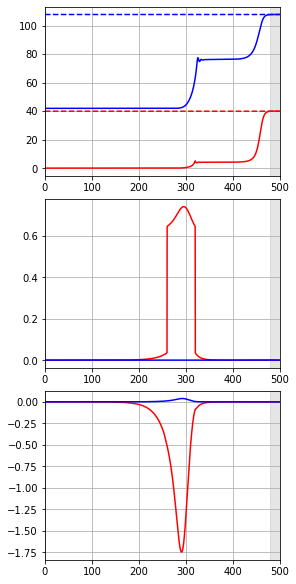

uncontrolled cost :  797.1477718037709
cost splitting :  0.006513201921346975 [5.40706012 0.        ]


In [27]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(10)

    control0[0,0,2600:3200] = -2.
    c_var = [0]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
        ax[1].plot(plot_time_array, bestControl_[i][0,0,n_pre-1:-n_post+1], color = 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[1].plot(plot_time_array, bestControl_[i][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')


        ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
        ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])    

In [21]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(60)

tol = 1e-13

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i == 20:
        continue
    
    while not conv[i]:

        weight_ = random.random() * ( cost_uncontrolled[i] -
                                     costnode_[i][0][0][0] ) / sum( costnode_[i][ind_cost][0][:] )
            
        aln.params.duration = dur
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][ind_cost][0][:2])

        if conv[i]:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]
        
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
            ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
            ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
            ax[0].set_xlim(-dur_pre,dur+dur_post)
            ax[1].set_xlim(-dur_pre,dur+dur_post)
            ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 30.352239374416076 0.0
interpolate adjoint :  True True True
initial cost =  330.8509496276394
RUN  0 , total integrated cost =  330.8509496276394
Gradient descend method:  None
RUN  1 , total integrated cost =  330.8509483869385
RUN  2 , total integrated cost =  330.85094838686047
RUN  3 , total integrated cost =  330.8509483868603
RUN  4 , total integrated cost =  330.8509483868602
RUN  5 , total integrated cost =  330.85094838685995
RUN  6 , total integrated cost =  330.85094838685995
Control only changes marginally.
RUN  6 , total integrated cost =  330.85094838685995
Improved over  6  iterations in  2.374955708000016  seconds by  3.750267154600806e-07  percent.
cost splitting :  7.287249460163111e-05 [7.04760944 3.85277061]
set cost params:  0.05 6.249400215086403 0.0
interpolate adjoint :  True True True
initial cost =  68.12084111246457
RUN  0 , total integ

KeyboardInterrupt: 

-------  20 0.4500000000000001 0.4750000000000002


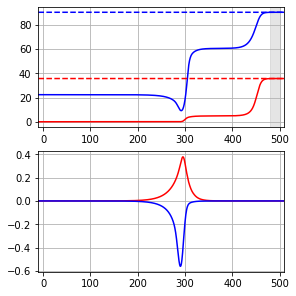

-------  50 0.47500000000000014 0.6000000000000003


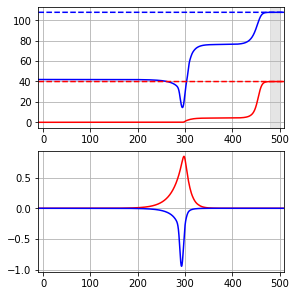

In [55]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()